# Predicting car insurance claims

We will attempt to train a model on the "train_auto" dataset to predict the variable "TARGET_FLAG", which describes whether or not a claim occurs, in the "test_auto" dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
X = pd.read_csv('train_auto.csv') 
X_test = pd.read_csv('test_auto.csv')
print(X.head)

<bound method NDFrame.head of       INDEX  TARGET_FLAG  TARGET_AMT  KIDSDRIV   AGE  HOMEKIDS   YOJ  \
0         1            0         0.0         0  60.0         0  11.0   
1         2            0         0.0         0  43.0         0  11.0   
2         4            0         0.0         0  35.0         1  10.0   
3         5            0         0.0         0  51.0         0  14.0   
4         6            0         0.0         0  50.0         0   NaN   
...     ...          ...         ...       ...   ...       ...   ...   
8156  10297            0         0.0         0  35.0         0  11.0   
8157  10298            0         0.0         1  45.0         2   9.0   
8158  10299            0         0.0         0  46.0         0   9.0   
8159  10301            0         0.0         0  50.0         0   7.0   
8160  10302            0         0.0         0  52.0         0  11.0   

        INCOME PARENT1  HOME_VAL  ... BLUEBOOK TIF     CAR_TYPE RED_CAR  \
0      $67,349      No        

## Examining and cleaning the data

In [2]:
#print names of columns with missing values and number of missing values in each column
missing_vals = (X.isnull().sum())
print(missing_vals[missing_vals > 0])

AGE           6
YOJ         454
INCOME      445
HOME_VAL    464
JOB         526
CAR_AGE     510
dtype: int64


None of the columns are missing a significant fraction of rows so we will impute missing values rather than drop those columns

In [3]:
def dollar_to_int(x):
    """Convert a string dollar amount to an int
    """
    if not isinstance(x, str):
        return x
    elif "$" not in x:
        return x
    return int(x.replace("$", "").replace(",", ""))
dollars = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
for col in dollars:
    X.loc[:, col] = X[col].apply(dollar_to_int)
    X.loc[:, col] = X[col].apply(dollar_to_int)
    X_test.loc[:, col] = X_test[col].apply(dollar_to_int)
    X_test.loc[:, col] = X_test[col].apply(dollar_to_int)
    
#print columns with categorical values and unique categorical values of each column; check for obvious ordinality
for col in X.columns:
    if X[col].dtype == "object":
        print(col, X[col].unique())

PARENT1 ['No' 'Yes']
MSTATUS ['z_No' 'Yes']
SEX ['M' 'z_F']
EDUCATION ['PhD' 'z_High School' '<High School' 'Bachelors' 'Masters']
JOB ['Professional' 'z_Blue Collar' 'Clerical' 'Doctor' 'Lawyer' 'Manager' nan
 'Home Maker' 'Student']
CAR_USE ['Private' 'Commercial']
CAR_TYPE ['Minivan' 'z_SUV' 'Sports Car' 'Van' 'Panel Truck' 'Pickup']
RED_CAR ['yes' 'no']
REVOKED ['No' 'Yes']
URBANICITY ['Highly Urban/ Urban' 'z_Highly Rural/ Rural']


There is no obvious ordered behavior for "JOB", "CAR_TYPE" etc so we will replace categorical variables with a one-hot encoding rather than an ordinal encoding

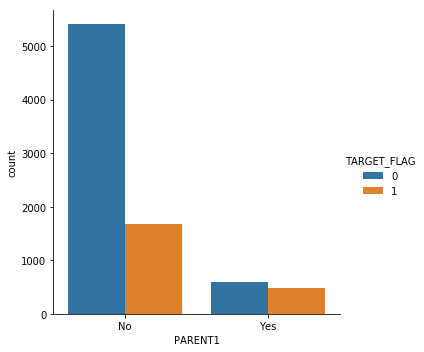

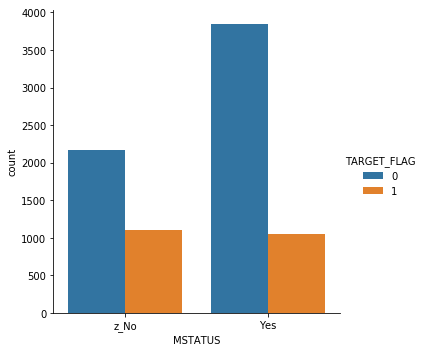

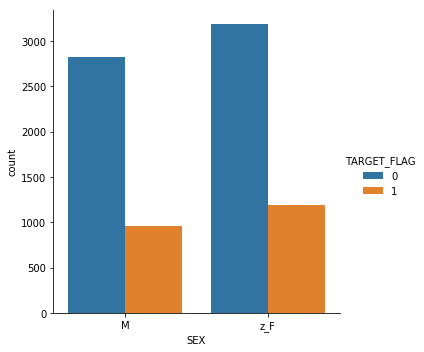

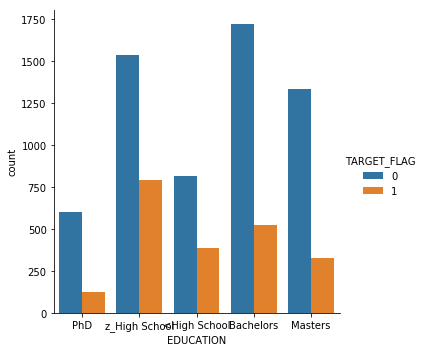

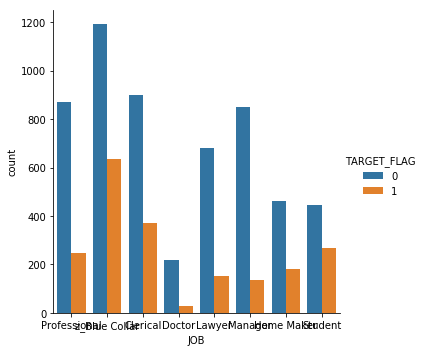

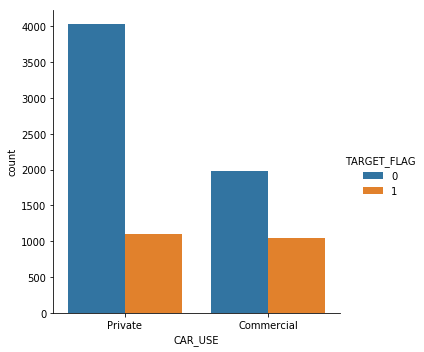

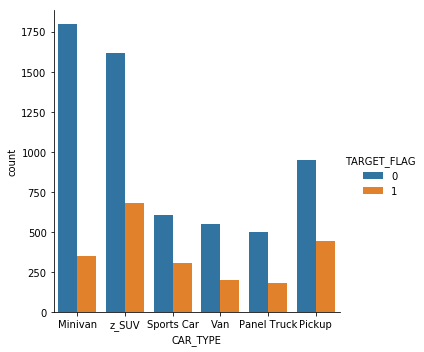

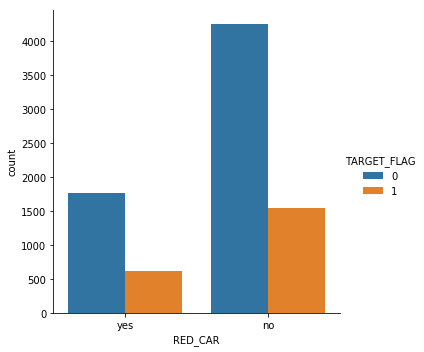

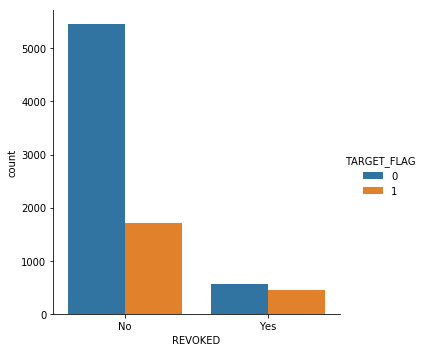

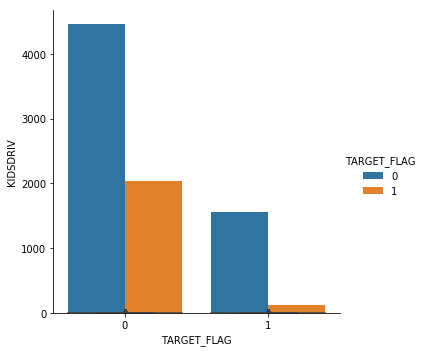

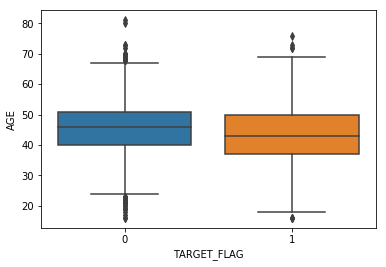

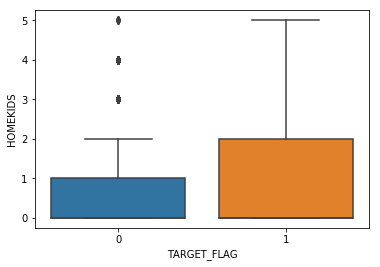

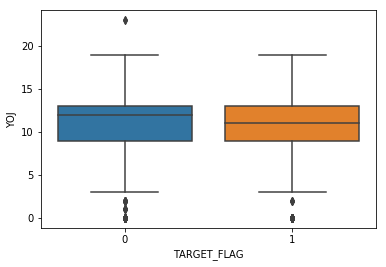

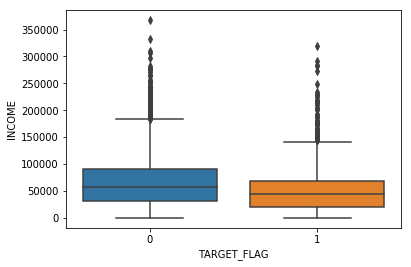

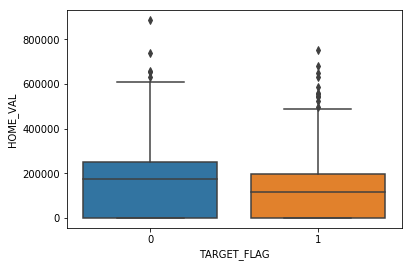

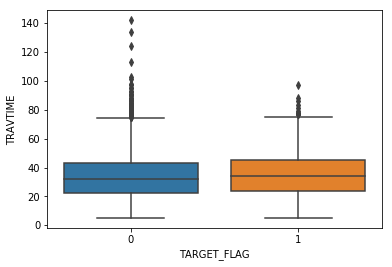

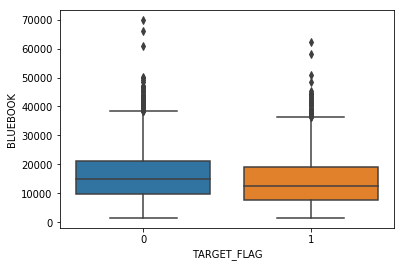

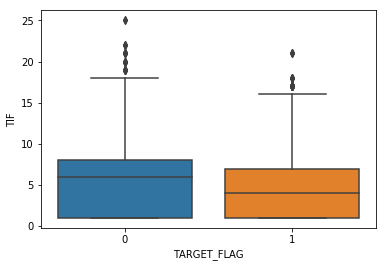

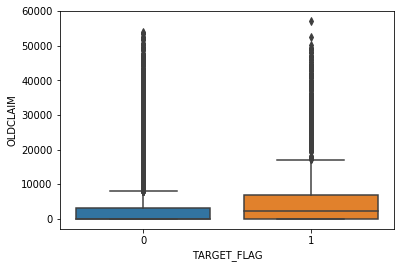

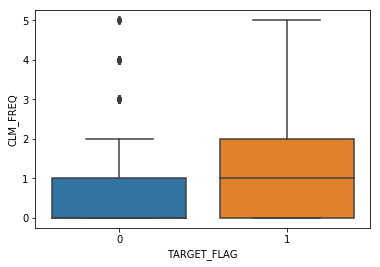

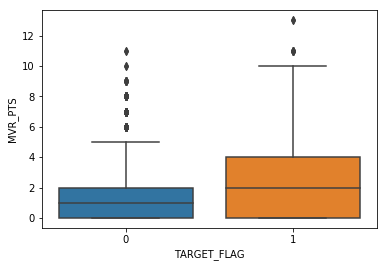

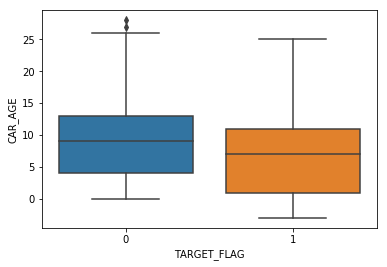

In [4]:
#plot relationships of each feature with the target variable

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

categorical_cols = X.select_dtypes(exclude="number").columns
numerical_cols = X.select_dtypes(include="number").columns[3:]


for col in categorical_cols:
    sns.catplot(x=col,hue='TARGET_FLAG',data=X,kind="count")

for col in numerical_cols:
#     sns.histplot(x=col,hue='TARGET_FLAG',data=X)
    sns.boxplot(x="TARGET_FLAG", y=col, data=X)
    plt.show()

In [5]:
#make sure no rows are missing target, remove targets from predictors
X.dropna(axis=0, subset=['TARGET_FLAG'], inplace=True)
y = X.TARGET_FLAG
X.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1, inplace=True)
X_test.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1, inplace=True)
print(X.head)

<bound method NDFrame.head of       INDEX  KIDSDRIV   AGE  HOMEKIDS   YOJ    INCOME PARENT1  HOME_VAL  \
0         1         0  60.0         0  11.0   67349.0      No       0.0   
1         2         0  43.0         0  11.0   91449.0      No  257252.0   
2         4         0  35.0         1  10.0   16039.0      No  124191.0   
3         5         0  51.0         0  14.0       NaN      No  306251.0   
4         6         0  50.0         0   NaN  114986.0      No  243925.0   
...     ...       ...   ...       ...   ...       ...     ...       ...   
8156  10297         0  35.0         0  11.0   43112.0      No       0.0   
8157  10298         1  45.0         2   9.0  164669.0      No  386273.0   
8158  10299         0  46.0         0   9.0  107204.0      No  332591.0   
8159  10301         0  50.0         0   7.0   43445.0      No  149248.0   
8160  10302         0  52.0         0  11.0   53235.0      No  197017.0   

     MSTATUS  SEX  ... BLUEBOOK TIF     CAR_TYPE RED_CAR  OLDCLAIM  C

In [6]:
print("Fraction of target flags that are zero: ", 1-y.sum()/len(y.index))
print("Correlation of numerical variables with target:")
print(X.corrwith(y))

Fraction of target flags that are zero:  0.7361842911407916
Correlation of numerical variables with target:
INDEX      -0.001670
KIDSDRIV    0.103668
AGE        -0.103217
HOMEKIDS    0.115621
YOJ        -0.070512
INCOME     -0.142008
HOME_VAL   -0.183737
TRAVTIME    0.048368
BLUEBOOK   -0.103383
TIF        -0.082370
OLDCLAIM    0.138084
CLM_FREQ    0.216196
MVR_PTS     0.219197
CAR_AGE    -0.100651
dtype: float64


Note that the dataset is imbalanced so even a simple majority classifier will have reasonably good accuracy (73.6%).

None of the numerical variables correlate particularly strongly with the target; note as a sanity check, "OLDCLM", "CLM_FREQ", and "MVR_PTS" (existence of an old claim, frequency of old claims, and the number of points on a driver's motor vehicle record) are the strongest positive predictors of a future claim.

## Building a model
### Common classifiers

Since "TARGET_FLAG" is a binary variable, we will try to model it with a classifier. After processing the data (imputation, scaling for numerical data and encoding for categorical data), we will loop through several common classifier models: decision tree, random forest, naive Bayes, k nearest neighbors, and support vector classifiers. For each we perform a cross-validated grid search over a few parameters with 5-fold cross-validation. For cross-validation we will use the F-score as our scoring parameter rather than accuracy, since as mentioned above, the dataset is imbalanced.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np

#preprocessing
#replace missing numeric values with the mean of that column, scale each column
numeric_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), 
                                   ("scale", StandardScaler())
                                  ])
#replace missing categorical values with the most frequent value in that column and convert using a one-hot encoding
categorical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])
preprocessor = ColumnTransformer(transformers=[('num', numeric_pipeline, numerical_cols),
                                               ('cat', categorical_pipeline, categorical_cols)
                                              ])
#list of models to try and corresponding sets of input parameters
models = [DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0), GaussianNB(),
          KNeighborsClassifier(), SVC(random_state=0)]
model_names = ["decision tree", "random forest", "naive Bayes", "k nearest neighbors", "SVC"]
hyperparams = [{"max_depth": [None, 10, 100, 500]},
               {"n_estimators": [10, 100, 500], "max_depth": [None, 10, 100, 500]},
               {'var_smoothing': [1e-9, 1e-5, 1e-3, 1e-1]},
               {'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']},
               {"kernel": ["poly", "rbf"], 'C': [0.1, 1, 10], "class_weight": [None, 'balanced']}]

#for each model, print the best f-score and corresponding best parameters found using GridSearchCV
for model, model_name, params in zip(models, model_names, hyperparams):
    pipe = Pipeline([('preprocessor',preprocessor),
                    ('gridsearch',GridSearchCV(model, param_grid=params, cv=5, scoring='f1'))
                    ])
    pipe.fit(X,y)
    print(model_name, ": best f-score: ", pipe['gridsearch'].best_score_, pipe["gridsearch"].best_params_)

decision tree : best f-score:  0.4571678335490409 {'max_depth': 10}
random forest : best f-score:  0.5003328561877615 {'max_depth': None, 'n_estimators': 500}
naive Bayes : best f-score:  0.5740837251596664 {'var_smoothing': 1e-09}
k nearest neighbors : best f-score:  0.4331699029662518 {'n_neighbors': 3, 'weights': 'distance'}
SVC : best f-score:  0.598059963910899 {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}


None of these models perform exceptionally well. If we use a more intuitive metric (accuracy)...

In [10]:
#for each model, print the best accuracy and corresponding best parameters found using GridSearchCV
for model, model_name, params in zip(models, model_names, hyperparams):
    pipe = Pipeline([('preprocessor',preprocessor),
                    ('gridsearch',GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy'))
                    ])
    pipe.fit(X,y)
    print(model_name, ": best accuracy: ", pipe['gridsearch'].best_score_, pipe["gridsearch"].best_params_)

decision tree : best accuracy:  0.7500302432669332 {'max_depth': 10}
random forest : best accuracy:  0.793040746610953 {'max_depth': None, 'n_estimators': 500}
naive Bayes : best accuracy:  0.7484375562839956 {'var_smoothing': 0.1}
k nearest neighbors : best accuracy:  0.7666949587550882 {'n_neighbors': 13, 'weights': 'uniform'}
SVC : best accuracy:  0.7934077182618301 {'C': 1, 'class_weight': None, 'kernel': 'rbf'}


...we can see that none of them are doing much better than the 73.6% accuracy of the majority classifier. However if we look at the accuracy of the best-performing model (SVC) after 5 cross-validation rounds, we can at least see that the mean accuracy is more than a few standard deviations above 73.6%.

In [11]:
#computing mean and std of accuracy of best model with 5 cross-validation rounds
model = SVC(kernel="rbf", C=1, class_weight=None, random_state=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(scores), np.std(scores))

0.793530267281438 0.006341958006840378


### Gradient boosting

Since none of these standard classifier models worked particularly well, we will next try gradient boosting since it is often highly accurate, again grid searching over some range of common parameter values.

In [12]:
import xgboost as xgb
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3]
}
xgb_cl = xgb.XGBClassifier()
xgbpipe = Pipeline([('preprocessor',preprocessor),
                    ('gridsearch',GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5, scoring="accuracy"))
                    ])
xgbpipe.fit(X,y)
print(xgbpipe["gridsearch"].best_score_)
print(xgbpipe["gridsearch"].best_params_)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7972064376883637
{'learning_rate': 0.01, 'n_estimators': 500}


This is slightly better than the SVC model but not by much. We could try other models and parameter combinations to try to improve our accuracy. However, noting that none of the numerical features correlate strongly with the target, we can infer that accurate predictions of future claims from this data set are likely difficult. In this case, it probably makes more sense to predict the probability of a future claim, rather than the absolute occurrence of one.

### Logistic regression

Therefore we attempt to model the data using logistic regression.

In [16]:
#evaluate the accuracy of a logistic regression model with 5-fold cross validation
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', logisticRegr)])
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5, n_jobs=-1)
print(np.mean(scores), np.std(scores))

0.7885069582027545 0.00784228647556243


Again the accuracy is not very good but here it is likely more meaningful to examine the predicted probabilities of future claims.

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0, 1)

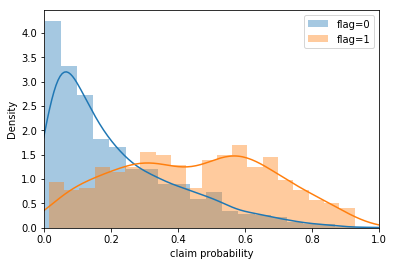

In [19]:
#split off validation data from the training data and preprocess
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
#fit the logistic regression model to the training data and predict probabilities of the validation data set
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
probs = logisticRegr.predict_proba(X_valid)
log_preds = logisticRegr.predict(X_valid)
#split the probabilities based on whether there actually was a claim in the validation set
probs_1 = probs[y_valid==1, 1]
probs_0 = probs[y_valid==0, 1]
#plot claim probability for both cases
sns.distplot(probs_0, bins=20, label="flag=0")
sns.distplot(probs_1, bins=20, label="flag=1")
ax=plt.gca()
ax.set(xlabel='claim probability')
plt.legend()
plt.xlim(0, 1)

Now we can see two distinct probability distributions for the cases where no claim occurs and where a claim does occur: in the case where there is no claim (blue), the predicted probability of a claim skews low although it has a long tail. Meanwhile in the case where there was a claim (orange), a much broader distribution of probabilities is predicted. In many cases where there actually was an accident, low probability was predicted, which is an issue for our model. Nevertheless, high claim probability is more likely to be predicted in the case where there actually was a claim, than when there wasn't.

We can look at this quantitatively by looking at some more metrics:

In [20]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_valid, log_preds))
print("Precision:",metrics.precision_score(y_valid, log_preds))
print("Recall:",metrics.recall_score(y_valid, log_preds))

Accuracy: 0.7899571341090018
Precision: 0.6333333333333333
Recall: 0.4491725768321513


Our precision is higher than our recall: not many cases where there was no claim are mislabeled as having a claim, but we are failing to identify a lot of cases where there was in fact a claim, as we can see in our plots.

## Making predictions on the test data set

Finally we use our logistic regression model to predict TARGET_FLAG in the test data set.

In [31]:
#prepare data frame for test predictions
test_pred = pd.DataFrame({'INDEX': X_test["INDEX"], 'TARGET_FLAG': np.zeros(len(X_test.index)),
                          'TARGET_FLAG_PROB': np.zeros(len(X_test.index))})
#apply imputer, encoder, etc to X_test
X_test_proc = preprocessor.transform(X_test)

In [32]:
#calculate predicted probabilities of claims, and whether or not a claim is predicted
test_pred["TARGET_FLAG_PROB"] = logisticRegr.predict_proba(X_test_proc)[:, 1]
test_pred["TARGET_FLAG"] = logisticRegr.predict(X_test_proc)

In [33]:
test_pred.head

<bound method NDFrame.head of       INDEX  TARGET_FLAG  TARGET_FLAG_PROB
0         3            0          0.128837
1         9            0          0.221101
2        10            0          0.121832
3        18            0          0.260094
4        21            0          0.176293
...     ...          ...               ...
2136  10279            0          0.260557
2137  10281            0          0.019054
2138  10285            0          0.006590
2139  10294            0          0.315083
2140  10300            0          0.149499

[2141 rows x 3 columns]>

In [35]:
print(test_pred["TARGET_FLAG"].sum()/len(test_pred.index))

0.17468472676319477


In [36]:
test_pred.to_csv('predicted_flag_and_prob.csv')